## Import Libraries:

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
import numpy as np
import pandas as pd
import datetime as dt
import config as cfg
import missingno as msno
import s3fs

from sqlalchemy import create_engine
import psycopg2

### Import Data from Postgre DB - 'weather_aus_raw' table

In [69]:
# import data from AWS RDS Database
conn_string = "host="+cfg.PGHOST +" port="+ "5432" +" dbname="+ cfg.PGDATABASE +" user=" + cfg.PGUSER \
                  +" password="+ cfg.PGPASSWORD
    
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

df = pd.read_sql_query('select * from weather_aus_raw',  conn)
df

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,2008-12-01,Albury,13.4,22.9,0.6,9999.0,9999.0,W,44.0,W,...,1007.1,8.0,9999.0,16.9,21.8,No,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,9999.0,9999.0,WNW,44.0,NNW,...,1007.8,9999.0,9999.0,17.2,24.3,No,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,9999.0,9999.0,WSW,46.0,W,...,1008.7,9999.0,2.0,21.0,23.2,No,No,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,9999.0,9999.0,NE,24.0,SE,...,1012.8,9999.0,9999.0,18.1,26.5,No,No,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,9999.0,9999.0,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,9999.0,9999.0,E,31.0,SE,...,1020.3,9999.0,9999.0,10.1,22.4,No,No,2017,6,21
145456,2017-06-22,Uluru,3.6,25.3,0.0,9999.0,9999.0,NNW,22.0,SE,...,1019.1,9999.0,9999.0,10.9,24.5,No,No,2017,6,22
145457,2017-06-23,Uluru,5.4,26.9,0.0,9999.0,9999.0,N,37.0,SE,...,1016.8,9999.0,9999.0,12.5,26.1,No,No,2017,6,23
145458,2017-06-24,Uluru,7.8,27.0,0.0,9999.0,9999.0,SE,28.0,SSE,...,1016.5,3.0,2.0,15.1,26.0,No,No,2017,6,24


### Data Analysis
#### Dataset contains daily weather observations from various Australian weather stations with ~145krows of data over 26 columns

In [70]:
df.shape

(145460, 26)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           145460 non-null  object 
 1   location       145460 non-null  object 
 2   mintemp        145460 non-null  float64
 3   maxtemp        145460 non-null  float64
 4   rainfall       145460 non-null  float64
 5   evaporation    145460 non-null  float64
 6   sunshine       145460 non-null  float64
 7   windgustdir    145460 non-null  object 
 8   windgustspeed  145460 non-null  float64
 9   winddir9am     145460 non-null  object 
 10  winddir3pm     145460 non-null  object 
 11  windspeed9am   145460 non-null  float64
 12  windspeed3pm   145460 non-null  float64
 13  humidity9am    145460 non-null  float64
 14  humidity3pm    145460 non-null  float64
 15  pressure9am    145460 non-null  float64
 16  pressure3pm    145460 non-null  float64
 17  cloud9am       145460 non-nul

In [72]:
## Replace '9999's with null
df = df.replace('9999', np.nan)
df = df.replace(9999, np.nan)
df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
year               int64
month              int64
day                int64
dtype: object

In [73]:
df

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,1020.3,NaN,NaN,10.1,22.4,No,No,2017,6,21
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,1019.1,NaN,NaN,10.9,24.5,No,No,2017,6,22
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,1016.8,NaN,NaN,12.5,26.1,No,No,2017,6,23
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,1016.5,3.0,2.0,15.1,26.0,No,No,2017,6,24


In [74]:
print('raintoday unique value count:  \n', df['raintoday'].value_counts())
print('\nunique location count: ', df['location'].nunique())
print('\nraintomorrow: ' , df['raintomorrow'].unique())
print('\nwindgustdir: ' , df['windgustdir'].unique())
print('\nHumidity3pm: ' , df['humidity3pm'].unique())
print("\nMissing Values :: \n",df.isnull().any())

raintoday unique value count:  
 No     110319
Yes     31880
Name: raintoday, dtype: int64

unique location count:  49

raintomorrow:  ['No' 'Yes' nan]

windgustdir:  ['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']

Humidity3pm:  [ 22.  25.  30.  16.  33.  23.  19.   9.  27.  91.  93.  43.  32.  28.
  82.  65.  26.  24.  17.  15.  70.  12.   8.  31.  20.  10.  21.  39.
  13.  11.  69.  18.  14.  35.  90.  68.  74.  41.  34.  78.  49.  37.
  42.  47.  52.  29.  86.  89.  62.  79.  48.  46.  38.  44.  51.  36.
  45.  40.  53.  61.  59.  63.  54.  57.  50.  58.  75.  97.  80.  95.
  56.  72.  60.  71.  73.  81.  76.  64.  87.  85.  67.  55.  77.  84.
   7.  99.  92.  66.  83.  94.  96.  88.  nan 100.  98.   5.   6.   1.
   4.   2.   3.   0.]

Missing Values :: 
 date             False
location         False
mintemp           True
maxtemp           True
rainfall          True
evaporation       True
sunshine          True
windgustdir       True
win

### Handle Null Values

In [75]:
df = df.dropna(axis=0, subset=['raintomorrow'])
df = df.dropna(axis=0, subset=['raintoday'])
# Hanlde Nan in numeric columns
num_cols = df.select_dtypes('float64').columns.to_list()
print('\n float columns: ', num_cols)

for col in num_cols:
    df[col].fillna(df[col].mean(),inplace=True)
    
# Hanlde Nan in object columns
obj_cols = df.select_dtypes('object').columns.to_list()
print('\n object columns: ', obj_cols)

for col in obj_cols:
    df[col].fillna(df[col].mode(),inplace=True)    

df = df.reset_index(drop=True)

df



 float columns:  ['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'windgustspeed', 'windspeed9am', 'windspeed3pm', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm']

 object columns:  ['date', 'location', 'windgustdir', 'winddir9am', 'winddir3pm', 'raintoday', 'raintomorrow']


,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,2008-12-01,Albury,13.4,22.9,0.6,5.472516,7.63054,W,44.0,W,...,1007.1,8.000000,4.49925,16.9,21.8,No,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,5.472516,7.63054,WNW,44.0,NNW,...,1007.8,4.431161,4.49925,17.2,24.3,No,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,5.472516,7.63054,WSW,46.0,W,...,1008.7,4.431161,2.00000,21.0,23.2,No,No,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,5.472516,7.63054,NE,24.0,SE,...,1012.8,4.431161,4.49925,18.1,26.5,No,No,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,5.472516,7.63054,W,41.0,ENE,...,1006.0,7.000000,8.00000,17.8,29.7,No,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140782,2017-06-20,Uluru,3.5,21.8,0.0,5.472516,7.63054,E,31.0,ESE,...,1021.2,4.431161,4.49925,9.4,20.9,No,No,2017,6,20
140783,2017-06-21,Uluru,2.8,23.4,0.0,5.472516,7.63054,E,31.0,SE,...,1020.3,4.431161,4.49925,10.1,22.4,No,No,2017,6,21
140784,2017-06-22,Uluru,3.6,25.3,0.0,5.472516,7.63054,NNW,22.0,SE,...,1019.1,4.431161,4.49925,10.9,24.5,No,No,2017,6,22
140785,2017-06-23,Uluru,5.4,26.9,0.0,5.472516,7.63054,N,37.0,SE,...,1016.8,4.431161,4.49925,12.5,26.1,No,No,2017,6,23


<AxesSubplot:>

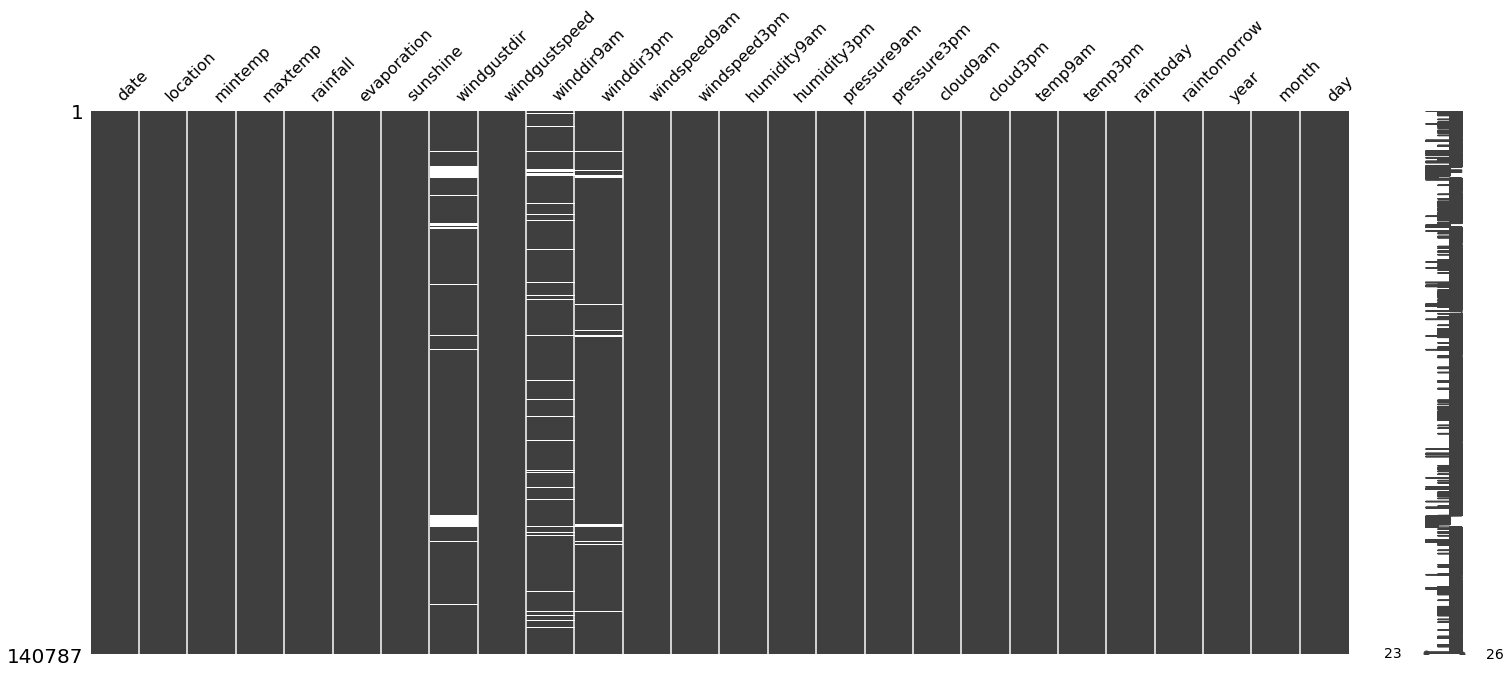

In [76]:
#Check how NAN Values are distributed in our Data Set
#Missingno library offers a very nice way to visualize the distribution of NaN values.
msno.matrix(df)

In [77]:
#Count of null values for each Column
df.isnull().sum().sort_values()

date                0
year                0
raintomorrow        0
raintoday           0
temp3pm             0
temp9am             0
cloud3pm            0
cloud9am            0
pressure3pm         0
pressure9am         0
humidity3pm         0
humidity9am         0
windspeed3pm        0
windspeed9am        0
windgustspeed       0
sunshine            0
evaporation         0
rainfall            0
maxtemp             0
mintemp             0
location            0
month               0
day                 0
winddir3pm       3670
windgustdir      9163
winddir9am       9660
dtype: int64

#### Drop the columns which are not necessary
##### winddir3pm, windgustdir, winddir9am columns are not needed for neither predicting for rainfall tomorrow nor draught

In [78]:
columns =  ['winddir3pm', 'windgustdir', 'winddir9am'] 
df = df.drop(columns, axis=1)

In [79]:
df.shape

(140787, 23)

<AxesSubplot:>

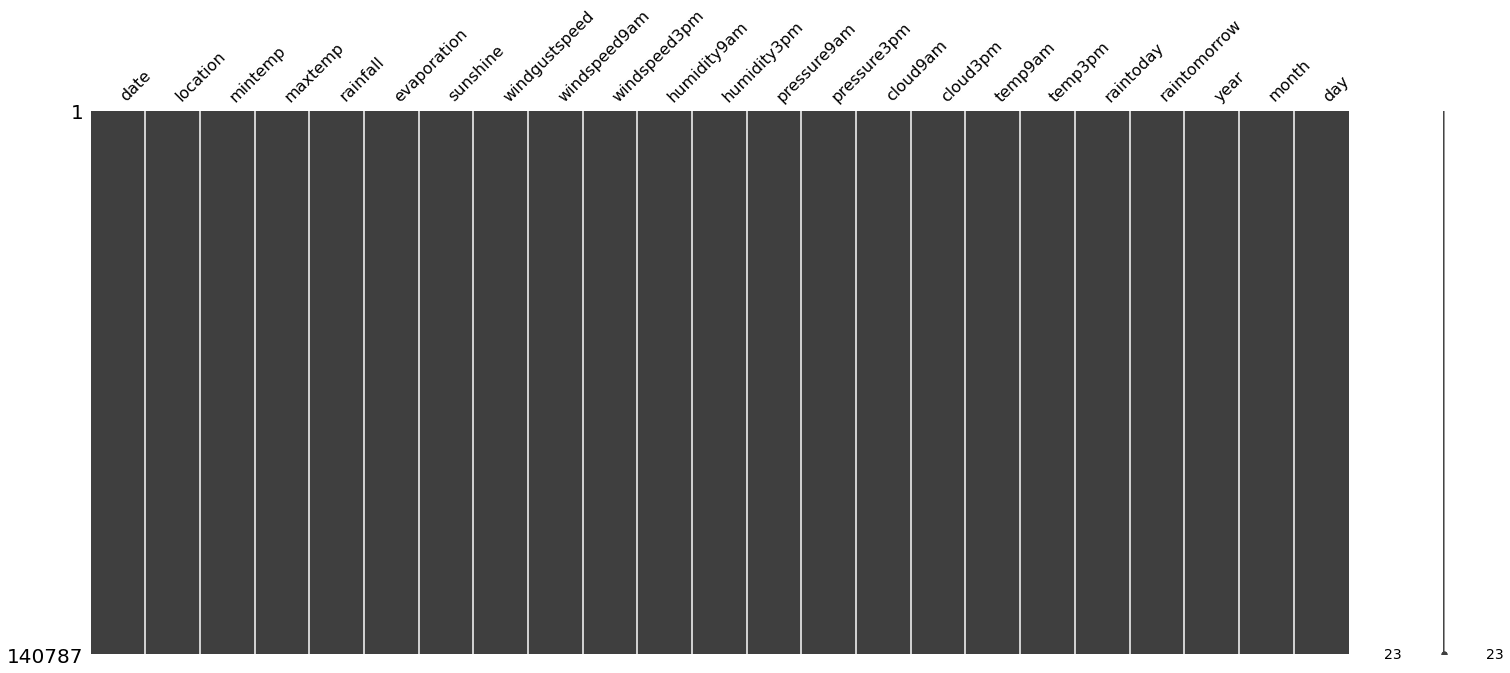

In [80]:
msno.matrix(df)

In [81]:
df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustspeed    float64
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
year               int64
month              int64
day                int64
dtype: object

In [82]:
# SQL command to create "weather_aus_clean" table
create_table = """
    CREATE TABLE IF NOT EXISTS weather_aus_clean(
	Date     date,
	Location varchar(32),
	MinTemp  float(16),
	MaxTemp  float(16),
	Rainfall float(16),
	Evaporation  float(16),
	Sunshine     float(16),
	WindGustSpeed  float(16),
	WindSpeed9am  float(16),
	WindSpeed3pm  float(16),
	Humidity9am   float(16),
	Humidity3pm   float(16),
	Pressure9am   float(16),
	Pressure3pm   float(16),
	Cloud9am      float(16),
	Cloud3pm      float(16),
	Temp9am       float(16),
	Temp3pm       float(16),
	RainToday     varchar(16),
	RainTomorrow  varchar(16),
	Year integer,
	Month integer,
	Day integer
);
    """

# Execute SQL Command and commit to DB
cur.execute(create_table)
conn.commit()


In [83]:
# Export the clean WeatherAUS data to weatherAus_clean.csv
df.to_csv (r'resources/weatherAus_clean.csv', index = False, header=True)

In [84]:
#Load the data in to "weather_aus_clean" DB Table from "weatherAus_clean.csv"file
#Verify the data is loaded
weather_aus_clean_df = pd.read_sql_query('select * from weather_aus_clean',  conn)
weather_aus_clean_df

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,windspeed9am,windspeed3pm,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,2008-12-01,Albury,13.4,22.9,0.6,5.468232,7.611177,44.0,20.0,24.0,...,1007.1,8.000000,4.50993,16.9,21.8,No,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,5.468232,7.611177,44.0,4.0,22.0,...,1007.8,4.447461,4.50993,17.2,24.3,No,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,5.468232,7.611177,46.0,19.0,26.0,...,1008.7,4.447461,2.00000,21.0,23.2,No,No,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,5.468232,7.611177,24.0,11.0,9.0,...,1012.8,4.447461,4.50993,18.1,26.5,No,No,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,5.468232,7.611177,41.0,7.0,20.0,...,1006.0,7.000000,8.00000,17.8,29.7,No,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140782,2017-06-20,Uluru,3.5,21.8,0.0,5.468232,7.611177,31.0,15.0,13.0,...,1021.2,4.447461,4.50993,9.4,20.9,No,No,2017,6,20
140783,2017-06-21,Uluru,2.8,23.4,0.0,5.468232,7.611177,31.0,13.0,11.0,...,1020.3,4.447461,4.50993,10.1,22.4,No,No,2017,6,21
140784,2017-06-22,Uluru,3.6,25.3,0.0,5.468232,7.611177,22.0,13.0,9.0,...,1019.1,4.447461,4.50993,10.9,24.5,No,No,2017,6,22
140785,2017-06-23,Uluru,5.4,26.9,0.0,5.468232,7.611177,37.0,9.0,9.0,...,1016.8,4.447461,4.50993,12.5,26.1,No,No,2017,6,23


In [85]:
cities_df=pd.read_sql_query('select * from cities_aus',conn)
cities_df

,location,state,country,latitude,longitide,population,timezone
0,Adelaide,South Australia,Australia,-34.9273,138.5995,"1,376,601",Cen. Australia Standard Time
1,Albany,Western Australia,Australia,-35.0238,117.8847,"34,205",W. Australia Standard Time
2,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time
3,AliceSprings,Northern Territory,Australia,-23.7000,133.8700,"26,534",AUS Central Standard Time
4,BadgerysCreek,New South Wales,Australia,-33.8796,150.7523,225,AUS Eastern Standard Time
5,Ballarat,Victoria,Australia,-37.5609,143.8550,"109,553",AUS Eastern Standard Time
6,Bendigo,Victoria,Australia,-36.7593,144.2840,"100,632",AUS Eastern Standard Time
7,Brisbane,Queensland,Australia,-27.4700,153.0230,"2,560,700",AUS Eastern Standard Time
8,Cairns,Queensland,Australia,-16.9256,145.7753,"153,951",AUS Eastern Standard Time
9,Canberra,Australian Capital Territory,Australia,-35.3075,149.1244,"431,380",AUS Eastern Standard Time


In [91]:
#Merge both "weather_aus_clean" and "cities_aus" tables 
merge_df = pd.read_sql_query('select cities.location, cities.state, cities.country,cities.latitude, cities.Longitide, cities.population, cities.timezone,clean.date, clean.MinTemp, clean.MaxTemp, clean.Rainfall, clean.Evaporation,clean.Sunshine, clean.WindGustSpeed, clean.WindSpeed9am, clean.WindSpeed3pm,clean.Humidity9am, clean.Humidity3pm, clean.Pressure9am, clean.Pressure3pm,clean.Cloud9am, clean.Cloud3pm, clean.Temp9am, Clean.Temp3pm, Clean.RainToday,Clean.RainTomorrow, clean.Year, clean.Month, clean.day from cities_aus cities inner join weather_aus_clean clean on cities.location=clean.location',  conn)
merge_df

,location,state,country,latitude,longitide,population,timezone,date,mintemp,maxtemp,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-01,13.4,22.9,...,1007.1,8.000000,4.50993,16.9,21.8,No,No,2008,12,1
1,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-02,7.4,25.1,...,1007.8,4.447461,4.50993,17.2,24.3,No,No,2008,12,2
2,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-03,12.9,25.7,...,1008.7,4.447461,2.00000,21.0,23.2,No,No,2008,12,3
3,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-04,9.2,28.0,...,1012.8,4.447461,4.50993,18.1,26.5,No,No,2008,12,4
4,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-05,17.5,32.3,...,1006.0,7.000000,8.00000,17.8,29.7,No,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137858,Uluru,Northern Territory,Australia,-25.3444,131.0369,1099,AUS Central Standard Time,2017-06-20,3.5,21.8,...,1021.2,4.447461,4.50993,9.4,20.9,No,No,2017,6,20
137859,Uluru,Northern Territory,Australia,-25.3444,131.0369,1099,AUS Central Standard Time,2017-06-21,2.8,23.4,...,1020.3,4.447461,4.50993,10.1,22.4,No,No,2017,6,21
137860,Uluru,Northern Territory,Australia,-25.3444,131.0369,1099,AUS Central Standard Time,2017-06-22,3.6,25.3,...,1019.1,4.447461,4.50993,10.9,24.5,No,No,2017,6,22
137861,Uluru,Northern Territory,Australia,-25.3444,131.0369,1099,AUS Central Standard Time,2017-06-23,5.4,26.9,...,1016.8,4.447461,4.50993,12.5,26.1,No,No,2017,6,23


<AxesSubplot:>

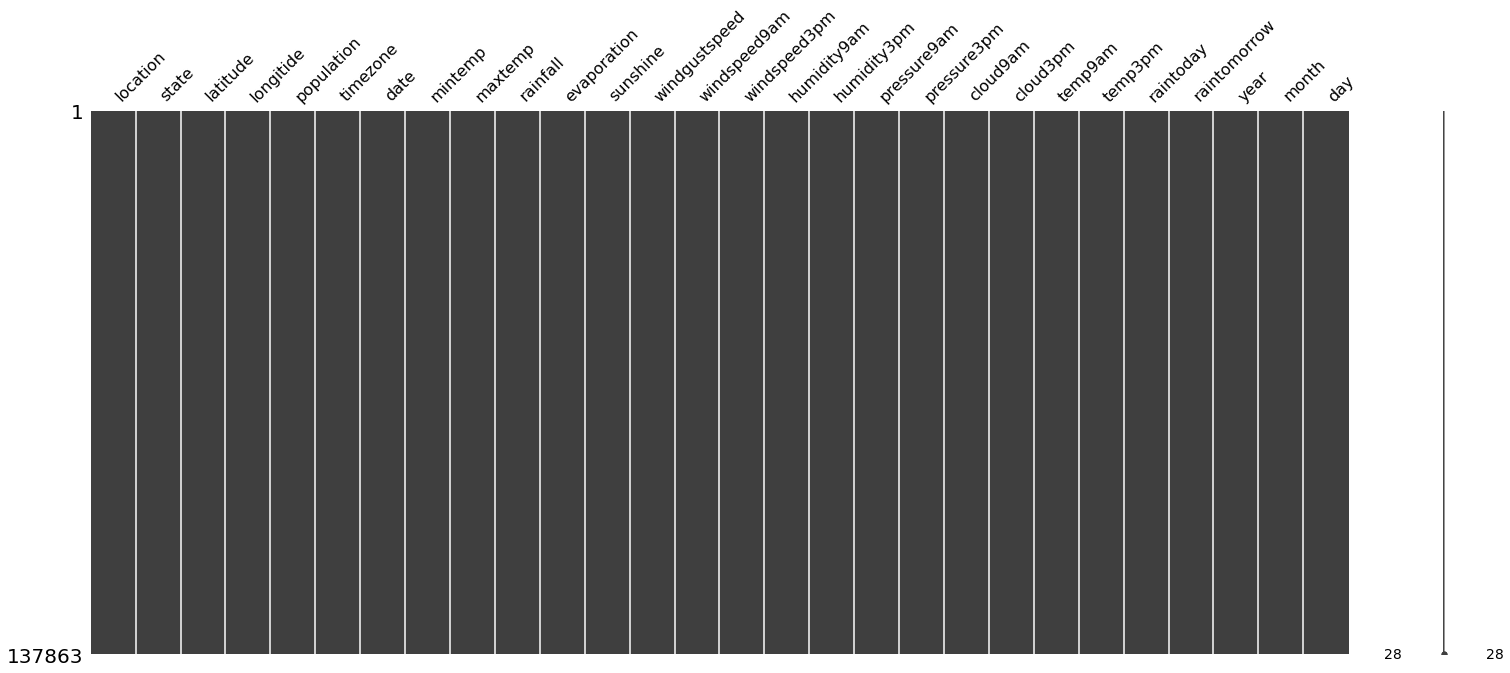

In [87]:
msno.matrix(merge_df)

In [88]:
# SQL command to create "weather_aus_merge" table
create_table = """
    CREATE TABLE IF NOT EXISTS weather_aus_merge(
    Location varchar(32),
	State  varchar(32),
	Country  varchar(32),
	Latitude float(16),
	Longitide float(16),
	Population varchar(32),
	Timezone  varchar(64),
	Date date,
	MinTemp  float(16),
	MaxTemp  float(16),
	Rainfall float(16),
	Evaporation  float(16),
	Sunshine     float(16),
	WindGustSpeed  float(16),
	WindSpeed9am  float(16),
	WindSpeed3pm  float(16),
	Humidity9am   float(16),
	Humidity3pm   float(16),
	Pressure9am   float(16),
	Pressure3pm   float(16),
	Cloud9am      float(16),
	Cloud3pm      float(16),
	Temp9am       float(16),
	Temp3pm       float(16),
	RainToday     varchar(16),
	RainTomorrow  varchar(16),
	Year integer,
	Month integer,
	Day integer
);
    """

# Execute SQL Command and commit to DB
cur.execute(create_table)
conn.commit()

In [92]:
# Export the clean WeatherAUS data to weatherAus_merge.csv
merge_df.to_csv (r'resources/weatherAus_merge.csv', index = False, header=True)

In [93]:
#Load the data in to "weather_aus_clean" DB Table from "weatherAus_merge.csv"file
#Verify the data is loaded
weather_aus_clean_df = pd.read_sql_query('select * from weather_aus_merge',  conn)
weather_aus_clean_df

,location,state,country,latitude,longitide,population,timezone,date,mintemp,maxtemp,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-01,13.4,22.9,...,1007.1,8.000000,4.50993,16.9,21.8,No,No,2008,12,1
1,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-02,7.4,25.1,...,1007.8,4.447461,4.50993,17.2,24.3,No,No,2008,12,2
2,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-03,12.9,25.7,...,1008.7,4.447461,2.00000,21.0,23.2,No,No,2008,12,3
3,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-04,9.2,28.0,...,1012.8,4.447461,4.50993,18.1,26.5,No,No,2008,12,4
4,Albury,New South Wales,Australia,-36.0808,146.9165,"47,974",AUS Eastern Standard Time,2008-12-05,17.5,32.3,...,1006.0,7.000000,8.00000,17.8,29.7,No,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137858,Uluru,Northern Territory,Australia,-25.3444,131.0369,1099,AUS Central Standard Time,2017-06-20,3.5,21.8,...,1021.2,4.447461,4.50993,9.4,20.9,No,No,2017,6,20
137859,Uluru,Northern Territory,Australia,-25.3444,131.0369,1099,AUS Central Standard Time,2017-06-21,2.8,23.4,...,1020.3,4.447461,4.50993,10.1,22.4,No,No,2017,6,21
137860,Uluru,Northern Territory,Australia,-25.3444,131.0369,1099,AUS Central Standard Time,2017-06-22,3.6,25.3,...,1019.1,4.447461,4.50993,10.9,24.5,No,No,2017,6,22
137861,Uluru,Northern Territory,Australia,-25.3444,131.0369,1099,AUS Central Standard Time,2017-06-23,5.4,26.9,...,1016.8,4.447461,4.50993,12.5,26.1,No,No,2017,6,23
